In [55]:
# pip install imbalanced-learn==0.6
# pip install scikit-learn==0.22.1
# pip install torch===1.5.1 torchvision===0.6.1 -f https://download.pytorch.org/whl/torch_stable.html

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score, accuracy_score, classification_report
import lightgbm as lgbm
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from imblearn.over_sampling import SMOTE, ADASYN
# from imblearn.under_sampling import CondensedNearestNeighbour, NearMiss, EditedNearestNeighbours
from sklearn.svm import SVC
import xgboost 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
# from bass import *
from scipy import sparse
from sklearn.ensemble import BaggingClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [70]:
# Reading files

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
combined_2.isnull().sum()

NameError: name 'combined_2' is not defined

In [4]:
combined_2.dtypes

NameError: name 'combined_2' is not defined

### Feature engineering

In [5]:
train_id = train[['ID']]
test_id = test[['ID']]
train_op = train[['Segmentation']]

In [6]:
label_enc = LabelEncoder()
train_op['Segmentation'] = label_enc.fit_transform(train_op['Segmentation'])

C:\Users\bimaljeet\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
train = train.drop(['ID', 'Segmentation'], axis = 1)
test = test.drop(['ID'], axis = 1)

In [8]:
train['trainable'] = 1
test['trainable'] = 0

combined = pd.concat((train, test), axis = 0)

In [9]:
combined['Spending_Score'] = np.where(combined['Spending_Score']=='Low',1, np.where(combined['Spending_Score']=='Average',2,
                                                       np.where(combined['Spending_Score']=='High',3,np.NaN)))
combined['Gender'] = np.where(combined['Gender']=='Male',1,0)
combined['Ever_Married'] = np.where(combined['Ever_Married']=='Yes',1, np.where(combined['Ever_Married']=='No',0,np.NaN))
combined['Graduated'] = np.where(combined['Graduated']=='Yes',1, np.where(combined['Graduated']=='No',0,np.NaN))

In [10]:
combined['Ever_Married_NA'] = np.where(combined['Ever_Married'].isnull(),1,0)
combined['Graduated_NA'] = np.where(combined['Graduated'].isnull(),1,0)
combined['Profession_NA'] = np.where(combined['Profession'].isnull(),1,0)
combined['Work_Experience_NA'] = np.where(combined['Work_Experience'].isnull(),1,0)
combined['Family_Size_NA'] = np.where(combined['Family_Size'].isnull(),1,0)
combined['Var_1_NA'] = np.where(combined['Var_1'].isnull(),1,0)

In [11]:
# Iterative imputation on profession
iter_profession1 = combined.iloc[:,[0,1,2,3,4,5,6,7,9,10,11,12,13,14,15]]

train_profession = iter_profession1[iter_profession1.Profession.notnull()]
test_profession = iter_profession1[iter_profession1.Profession.isnull()]
test_profession.drop(['Profession'], axis =1, inplace = True)

y_tr_profession = train_profession[['Profession']]
X_tr_profession = train_profession.drop(['Profession'], axis = 1)

C:\Users\bimaljeet\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [12]:
label_enc = LabelEncoder()
y_tr_profession = label_enc.fit_transform(y_tr_profession)
y_tr_profession = pd.DataFrame(y_tr_profession)

C:\Users\bimaljeet\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [13]:
impute = IterativeImputer()
X_tr_profession_impute = impute.fit_transform(X_tr_profession)
X_tr_profession_impute = pd.DataFrame(X_tr_profession_impute)
X_tr_profession_impute.columns = X_tr_profession.columns

X_test_profession_impute = impute.transform((test_profession))
X_test_profession_impute = pd.DataFrame(X_test_profession_impute)
X_test_profession_impute.columns = test_profession.columns

In [14]:
X_tr_profession, X_val_profession, y_tr_profession, y_val_profession = train_test_split(X_tr_profession_impute, y_tr_profession, test_size = 0.3, random_state = 42)

In [15]:
lgbm_try = RandomForestClassifier(n_estimators=100, max_depth=9)
lgbm_try.fit(X_tr_profession, y_tr_profession)

C:\Users\bimaljeet\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(max_depth=9)

In [16]:
print(lgbm_try.score(X_tr_profession, y_tr_profession))
print(lgbm_try.score(X_val_profession, y_val_profession))

0.5922962159229621
0.5379746835443038


In [17]:
predicted = pd.DataFrame(lgbm_try.predict(X_test_profession_impute), columns=['Profession'])

In [18]:
professional_complete = pd.concat((X_test_profession_impute, predicted), axis = 1)
professional_complete = professional_complete.iloc[:,[0,1,2,3,14,4,5,6,7,8,9,10,11,12,13]]

In [19]:
combined = combined[combined['Profession'].notnull()]

In [20]:
combined['Profession'] = label_enc.transform(combined['Profession'])

In [21]:
combined_2 = pd.concat((combined, professional_complete), axis = 0)

In [22]:
combined_2['Var_1'] = np.where(combined_2['Var_1'].isnull(),'Cat_6',combined_2['Var_1'])

In [23]:
combined_2_var = combined_2[['Var_1']]
OHE = OneHotEncoder(sparse=False)
combined_2_var = OHE.fit_transform(combined_2_var)
combined_2_var = pd.DataFrame(combined_2_var)
combined_2_var.columns = ['Cat_1', 'Cat_2', 'Cat_3', 'Cat_4', 'Cat_5', 'Cat_6', 'Cat_7']

In [24]:
combined_2.index = [i for i in range(10695)]

In [25]:
combined_2 = combined_2.drop(['Var_1'], axis = 1)

In [26]:
combined_3 = pd.concat((combined_2, combined_2_var), axis = 1)

In [27]:
combined_3_trainable = combined_3[combined_3.trainable==1]
combined_3_trainable = combined_3_trainable.drop(['trainable'], axis = 1)

combined_3_test = combined_3[combined_3.trainable==0]
combined_3_test = combined_3_test.drop(['trainable'], axis = 1)

In [28]:
impute = IterativeImputer()
combined_3_trainable_impute = impute.fit_transform(combined_3_trainable)
combined_3_trainable_impute = pd.DataFrame(combined_3_trainable_impute)
combined_3_trainable_impute.columns = combined_3_trainable.columns

combined_3_test_impute = impute.transform(combined_3_test)
combined_3_test_impute = pd.DataFrame(combined_3_test_impute)
combined_3_test_impute.columns = combined_3_test.columns

In [30]:
combined_3_trainable_impute

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Ever_Married_NA,Graduated_NA,...,Work_Experience_NA,Family_Size_NA,Var_1_NA,Cat_1,Cat_2,Cat_3,Cat_4,Cat_5,Cat_6,Cat_7
0,1.0,0.0,22.0,0.000000,5.0,1.000000,1.0,4.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,38.0,1.000000,2.0,3.055847,2.0,3.000000,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,67.0,1.000000,2.0,1.000000,1.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,1.0,67.0,1.000000,7.0,0.000000,3.0,2.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,40.0,1.000000,3.0,2.613358,3.0,6.000000,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8063,1.0,0.0,35.0,0.402894,3.0,0.000000,1.0,3.354987,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8064,0.0,0.0,27.0,0.000000,5.0,12.000000,1.0,3.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8065,0.0,1.0,47.0,0.000000,2.0,1.000000,1.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8066,0.0,1.0,66.0,0.000000,2.0,1.000000,2.0,2.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
OHE_2 = OneHotEncoder(sparse=False)
combined_3_trainable_impute

In [29]:
X = combined_3_trainable_impute
y = train_op
test = combined_3_test_impute

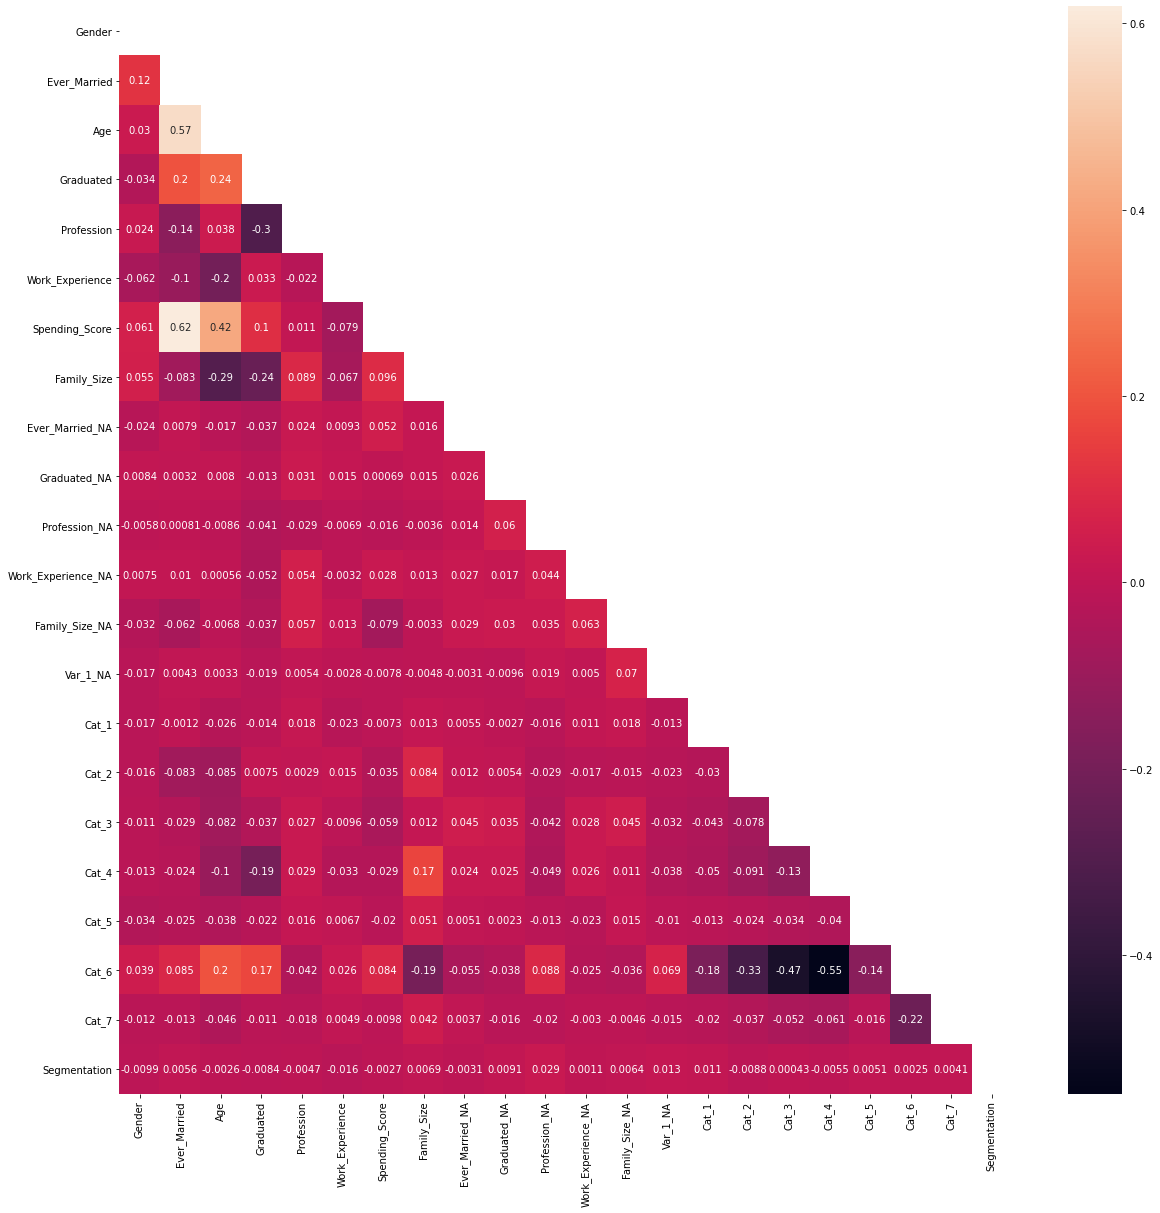

In [143]:
plt.figure(figsize=(20,20))
sns.heatmap((pd.concat((combined_3_trainable_impute, train_op), axis = 1)).corr(),annot=True, mask = np.triu((pd.concat((combined_3_trainable_impute, train_op), axis =1)).corr()))

## Model

#### In line

In [31]:
X_tr, X_val, y_tr, y_val = train_test_split(X.drop(['Profession'], axis = 1), y, test_size = 0.2, random_state = 42)

### LightGBM

In [32]:
lgbm_clf = lgbm.LGBMClassifier(n_estimators=500)
lgbm_clf.fit(X_tr, y_tr)

C:\Users\bimaljeet\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LGBMClassifier(n_estimators=500)

In [33]:
print(lgbm_clf.score(X_tr, y_tr))
print(lgbm_clf.score(X_val, y_val))

0.7269910133250698
0.24907063197026022


In [153]:
svm_clf = SVC(C=1000)
svm_clf.fit(X_tr, y_tr)

C:\Users\bimaljeet\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SVC(C=1000)

In [154]:
print(svm_clf.score(X_tr, y_tr))
print(svm_clf.score(X_val, y_val))

0.3027579795475674
0.26889714993804215


## Pre-engineered

In [95]:
# train_1 = pd.read_csv('train_1.csv')
train_1 = pd.read_csv('train_2.csv')

# test_1 = pd.read_csv('test_1_cleaned.csv')
test_1 = pd.read_csv('test_2.csv')

In [96]:
test_1.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,gender_0to1,gender_1to0,marry_1to0,marry_0to1,graduated_1to0,graduated_0to1,var_down,var_up,ID_change
0,1,1,61,1,1,5,0,3,5,1,0,0,0,0,0,0,0,0
1,0,1,88,1,7,1,1,4,5,0,1,0,0,0,0,0,0,0
2,1,0,31,0,0,1,0,2,5,0,0,0,0,0,0,1,0,0
3,1,1,60,1,0,2,1,5,5,1,0,0,1,0,1,0,1,0
4,0,1,51,1,0,3,1,6,5,0,1,0,1,0,1,0,1,0


In [97]:
train_1['age_before'] = np.where(train_1['Age']==23,1,(np.where(train_1['Age']==33,1,(np.where(train_1['Age']==43,1,(np.where(train_1['Age']==53,1,(np.where(train_1['Age']==63,1,0)))))))))
train_1['age_after'] = np.where(train_1['Age']==25,1,(np.where(train_1['Age']==35,1,(np.where(train_1['Age']==45,1,(np.where(train_1['Age']==55,1,(np.where(train_1['Age']==65,1,0)))))))))

test_1['age_before'] = np.where(test_1['Age']==23,1,(np.where(test_1['Age']==33,1,(np.where(test_1['Age']==43,1,(np.where(test_1['Age']==53,1,(np.where(test_1['Age']==63,1,0)))))))))
test_1['age_after'] = np.where(test_1['Age']==25,1,(np.where(test_1['Age']==35,1,(np.where(test_1['Age']==45,1,(np.where(test_1['Age']==55,1,(np.where(test_1['Age']==65,1,0)))))))))

In [98]:
train_1['Age_bucket'] = pd.cut(train_1['Age'], [17,23,33,43,53,63,90], 
                               include_lowest=True, labels=[17,23,33,43,53,63])
train_1['Age_bucket'] = train_1['Age_bucket'].astype(int)
train_1.drop(['Age'], axis = 1, inplace = True)

test_1['Age_bucket'] = pd.cut(test_1['Age'], [17,23,33,43,53,63,90], 
                               include_lowest=True, labels=[17,23,33,43,53,63])
test_1['Age_bucket'] = test_1['Age_bucket'].astype(int)
test_1.drop(['Age'], axis = 1, inplace = True)

In [99]:
train_1.head(10)

,Gender,Ever_Married,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,gender_0to1,gender_1to0,...,marry_0to1,graduated_1to0,graduated_0to1,var_down,var_up,ID_change,Segmentation,age_before,age_after,Age_bucket
0,1,1,1,4,1,2,3,5,0,0,...,0,0,0,0,0,0,3,0,0,53
1,0,1,1,4,0,2,5,5,0,1,...,0,0,0,0,0,0,3,1,0,53
2,1,1,1,0,0,1,3,5,1,0,...,0,0,0,0,0,0,3,0,0,33
3,1,0,0,5,1,0,4,5,0,0,...,0,1,0,0,0,0,4,1,0,17
4,1,0,0,5,7,0,4,5,0,0,...,0,0,0,0,0,0,4,0,0,17
5,0,1,1,7,0,2,2,5,0,1,...,1,0,1,0,0,0,3,0,0,63
6,0,0,0,8,2,0,3,5,0,0,...,0,1,0,0,0,0,4,0,0,23
7,0,1,1,2,1,0,1,5,0,0,...,1,0,1,0,0,0,2,0,0,33
8,0,1,1,2,0,0,1,5,0,0,...,0,0,0,0,0,1,2,0,0,33
9,0,1,0,7,1,2,3,5,0,0,...,0,1,0,0,0,0,4,0,0,63


In [100]:
y1 = train_1[['Segmentation']]

In [101]:
X1 = train_1.drop(['Segmentation'], axis = 1)

In [102]:
X_tr, X_val, y_tr, y_val = train_test_split(X1, y1, test_size = 0.2, random_state = 42)

In [103]:
X_tr.head(2)

,Gender,Ever_Married,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,gender_0to1,gender_1to0,marry_1to0,marry_0to1,graduated_1to0,graduated_0to1,var_down,var_up,ID_change,age_before,age_after,Age_bucket
561,1,1,1,0,2,0,2,5,1,0,0,1,0,1,0,0,0,0,0,43
1162,1,0,1,0,7,0,1,5,0,0,0,0,0,1,0,0,0,0,0,33


In [104]:
X_tr1 = X_tr.replace([-1],np.NaN)
X_val1 = X_val.replace([-1], np.NaN)

X_tr1.fillna(X_tr1['Ever_Married'].notnull().median(), inplace=True)
X_tr1.fillna(X_tr1['Graduated'].notnull().median(), inplace=True)
X_tr1.fillna(X_tr1['Profession'].notnull().median(), inplace=True)
X_tr1.fillna(X_tr1['Work_Experience'].notnull().median(), inplace=True)
X_tr1.fillna(X_tr1['Family_Size'].notnull().median(), inplace=True)
X_tr1.fillna(X_tr1['Var_1'].notnull().median(), inplace=True)

X_val1.fillna(X_val1['Ever_Married'].notnull().median(), inplace=True)
X_val1.fillna(X_val1['Graduated'].notnull().median(), inplace=True)
X_val1.fillna(X_val1['Profession'].notnull().median(), inplace=True)
X_val1.fillna(X_val1['Work_Experience'].notnull().median(), inplace=True)
X_val1.fillna(X_val1['Family_Size'].notnull().median(), inplace=True)
X_val1.fillna(X_val1['Var_1'].notnull().median(), inplace=True)

In [158]:
X_tr1 = X_tr.replace([-1],np.NaN)
X_val1 = X_val.replace([-1], np.NaN)

In [181]:
X_test1 = test_1.replace([-1], np.NaN)

In [167]:
iter_impute = IterativeImputer(initial_strategy='median', random_state=42)
X_tr_impute = iter_impute.fit_transform(X_tr1)
X_val_impute = iter_impute.transform(X_val1)

In [168]:
X_tr_impute = pd.DataFrame(X_tr_impute)
X_tr_impute.columns = X_tr1.columns

X_val_impute = pd.DataFrame(X_val_impute)
X_val_impute.columns = X_val1.columns

In [182]:
X_test_impute = iter_impute.transform(X_test1)

### LighGBM

In [169]:
# Extra features
lgbm_clf = lgbm.LGBMClassifier(n_estimators=3000, cat_feature = [0,1,2,3,7,8,9,10,11,12,13,14,15,16,17,18,19], label_gain = [5], num_leaves=8, max_depth=20, 
                               learning_rate=0.01, random_state=42, class_weight={1:1.2, 2:1., 3:1.15, 4:1.})
lgbm_clf.fit(X_tr_impute, y_tr)

C:\Users\bimaljeet\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LGBMClassifier(cat_feature=[0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                            18, 19],
               class_weight={1: 1.2, 2: 1.0, 3: 1.15, 4: 1.0}, label_gain=[5],
               learning_rate=0.01, max_depth=20, n_estimators=3000,
               num_leaves=8, random_state=42)

In [ ]:
{1:1.2, 2:1., 3:1.1, 4:1.} - 56.87%
{1:1.2, 2:1., 3:1.15, 4:1.} - 56.97%

In [11]:
lgbm_clf = lgbm.LGBMClassifier(n_estimators=10000, cat_feature = [0,1,2,3,7,8,9,10], label_gain = [5], num_leaves=8, max_depth=20, 
                               learning_rate=0.001, random_state=42, min_data_in_leaf = 100)
lgbm_clf.fit(X_tr, y_tr)

C:\Users\bimaljeet\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LGBMClassifier(cat_feature=[0, 1, 2, 3, 7, 8, 9, 10], label_gain=[5],
               learning_rate=0.001, max_depth=20, min_data_in_leaf=100,
               n_estimators=10000, num_leaves=8, random_state=42)

In [170]:
print(lgbm_clf.score(X_tr, y_tr))
print(lgbm_clf.score(X_val, y_val))

0.6182692307692308
0.5557692307692308


In [171]:
lgbm_clf1 = lgbm.LGBMClassifier(random_state=42, cat_feature = [0,1,2,3,7,8,9,10,11,12,13,14,15,16,17,18], label_gain = [5], objective='multiclass')

In [178]:
parameters = {'n_estimators':[10000,8000,4000,2000], 
             'num_leaves':[30,25,15],
             'learning_rate':[0.01,0.03, 0.05],
             'max_depth':[8,10,12,15],
             'min_data_in_leaf':[35,40,45],
             'reg_alpha':[i for i in np.arange(1.5,1.9,0.1)],
             'reg_lambda':[i for i in np.arange(1.5,1.9,0.1)],
             'subsample':[0.7]}
lgbm_grid = RandomizedSearchCV(estimator=lgbm_clf1,random_state=23, param_distributions=parameters, n_jobs=-1, cv = 5, scoring='accuracy', verbose=10)

In [179]:
lgbm_grid.fit(X_tr_impute, y_tr)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:  4.7min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:  4.8min remaining:   18.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.0min finished
C:\Users\bimaljeet\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(cat_feature=[0, 1, 2, 3, 7, 8, 9,
                                                         10, 11, 12, 13, 14, 15,
                                                         16, 17, 18],
                                            label_gain=[5],
                                            objective='multiclass',
                                            random_state=42),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.03, 0.05],
                                        'max_depth': [8, 10, 12, 15],
                                        'min_data_in_leaf': [35, 40, 45],
                                        'n_estimators': [10000, 8000, 4000,
                                                         2000],
                                        'num_leaves': [30, 25, 15],
                                        'reg_alpha': [1.5, 1.6,
                                 

In [177]:
lgbm_grid.best_params_

{'subsample': 0.7,
 'reg_lambda': 1.6000000000000003,
 'reg_alpha': 1.7000000000000002,
 'num_leaves': 15,
 'n_estimators': 4000,
 'min_data_in_leaf': 45,
 'max_depth': 12,
 'learning_rate': 0.01}

In [180]:
print(lgbm_grid.score(X_tr_impute, y_tr))
print(lgbm_grid.score(X_val_impute, y_val))

0.6771634615384615
0.5615384615384615


In [116]:
print(classification_report(y_val, lgbm_clf.predict(X_val)))

              precision    recall  f1-score   support

           1       0.46      0.59      0.52       519
           2       0.46      0.27      0.34       476
           3       0.60      0.65      0.62       492
           4       0.69      0.70      0.70       593

    accuracy                           0.56      2080
   macro avg       0.55      0.55      0.55      2080
weighted avg       0.56      0.56      0.55      2080



### XGBoost

In [462]:
xgb_clf = xgboost.XGBClassifier(n_estimators = 1000)
xgb_clf.fit(X_tr, y_tr)

XGBClassifier(n_estimators=1000, objective='multi:softprob',
              scale_pos_weight=1000)

In [463]:
print(xgb_clf.score(X_tr, y_tr))
print(xgb_clf.score(X_val, y_val))

0.64375
0.5461538461538461


### Neural Network

In [122]:
st_scale_nn = StandardScaler() 
st_scale_nn.fit(X_tr)
X_tr_nn = st_scale_nn.transform(X_tr)
X_val_nn = st_scale_nn.transform(X_val)
test_nn = st_scale_nn.transform(test_1)

In [127]:
X_tr_nn = torch.tensor(X_tr_nn)
X_val_nn = torch.tensor(X_val_nn)

y_tr_nn = torch.tensor(np.array(y_tr)).reshape(8320)
y_val_nn = torch.tensor(np.array(y_val)).reshape(2080)

C:\Users\bimaljeet\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
C:\Users\bimaljeet\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [132]:
print(X_tr_nn.shape)
print(X_val_nn.shape)
print(y_tr_nn.shape)
print(y_val_nn.shape)

print(X_tr_nn.dtype)
print(X_val_nn.dtype)
print(y_tr_nn.dtype)
print(y_val_nn.dtype)

torch.Size([8320, 20])
torch.Size([2080, 20])
torch.Size([8320])
torch.Size([2080])
torch.float64
torch.float64
torch.int64
torch.int64


In [136]:
class CustomerSegmentation(nn.Module):
    def __init__(self, debug):
        super().__init__()
        self.debug = debug
        self.l1_z = nn.Linear(20,100)
        self.l1_a = nn.Tanh()
        self.l2_z = nn.Linear(100,50)
        self.l2_a = nn.Tanh()
        self.l3_z = nn.Linear(50,20)
        self.l3_a = nn.Tanh()
        self.l4_z = nn.Linear(20,4)
        self.l4_a = nn.LogSoftmax()

    def forward(self,x):
        z1 = self.l1_z(x)
        a1 = self.l1_a(z1)
        if self.debug:print (a1.shape)
        z2 = self.l2_z(a1)
        a2 = self.l2_a(z2)
        if self.debug:print (a2.shape)
        z3 = self.l3_z(a2)
        a3 = self.l3_a(z3)
        if self.debug:print (a3.shape)
        z4 = self.l4_z(a3)
        a4 = self.l4_a(z4)
        if self.debug:print (a4.shape)
        return a4

In [138]:
created_classifier = CustomerSegmentation(debug=True)
x = torch.ones(1000,20)
op = created_classifier(x)

torch.Size([1000, 100])
torch.Size([1000, 50])
torch.Size([1000, 20])
torch.Size([1000, 4])


C:\Users\bimaljeet\anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [156]:
model = CustomerSegmentation(debug=False)
loss_fun = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [147]:
loss_fun(model(X_tr_nn.float()), y_tr_nn)

C:\Users\bimaljeet\anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


IndexError: Target 4 is out of bounds.

In [150]:
y_tr_nn.shape

torch.Size([8320])

In [157]:
for i in range(50):
    optimizer.zero_grad()
    output = model(X_tr_nn.float())
    loss = loss_fun(output, y_tr_nn)
    loss.backward()
    optimizer.step()
    print(i, loss.item())

C:\Users\bimaljeet\anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


IndexError: Target 4 is out of bounds.

### Visualization

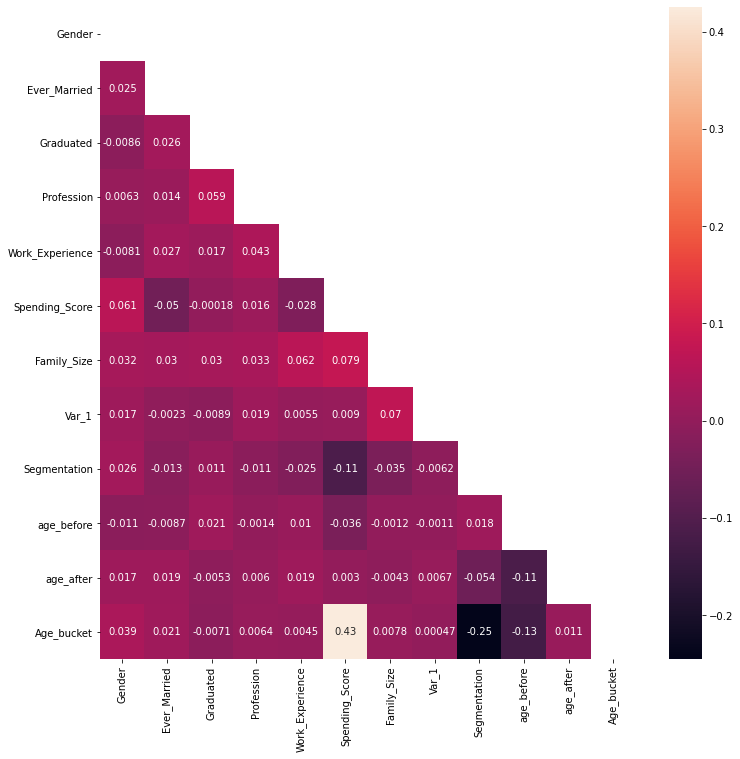

In [381]:
plt.figure(figsize=(12,12))
sns.heatmap(train_1.corr(),annot=True, mask = np.triu(train_1.corr()))

In [183]:
# Predict and write to file
predict = pd.DataFrame(lgbm_grid.predict(X_test_impute), columns=['p'])
predict = np.where(predict['p']==1,'A',np.where(predict['p']==2,'B',np.where(predict['p']==3,'C',np.where(predict['p']==4,'D',np.NaN))))
predict = pd.DataFrame(predict, columns=['Prediction'])
predict.to_csv('result_10.csv', index = False)

### K means

In [52]:
st_scale = StandardScaler()
st_scale.fit(X_tr1)
X_tr_kmeans = st_scale.transform(X_tr1)

In [56]:
mm_scale = MinMaxScaler()
mm_scale.fit(X_tr1)
X_tr_kmeans1 = mm_scale.transform(X_tr1)

In [57]:
kmeans_clst = KMeans(n_clusters=4, random_state=42, max_iter=1000)
kmeans_clst.fit(X_tr_kmeans1)

KMeans(max_iter=1000, n_clusters=4, random_state=42)

In [54]:
fitted = pd.DataFrame(kmeans_clst.labels_, columns=['k'])
fitted.groupby(['k'])['k'].count()

k
0    1100
1    2879
2    1137
3    3204
Name: k, dtype: int64

In [58]:
fitted = pd.DataFrame(kmeans_clst.labels_, columns=['k'])
fitted.groupby(['k'])['k'].count()

k
0    2921
1    1989
2    1662
3    1748
Name: k, dtype: int64

In [252]:
y_tr.groupby(['Segmentation'])['Segmentation'].count()

Segmentation
1    1581
2    1489
3    1590
4    1794
Name: Segmentation, dtype: int64

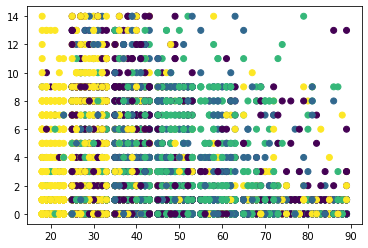

In [272]:
plt.scatter(train_1[train_1.Work_Experience != -999]['Age'], train_1[train_1.Work_Experience != -999]['Work_Experience'], c= train_1[train_1.Work_Experience != -999]['Segmentation'])
plt.show()

In [ ]:
plt.scatter(train_1[train_1.Work_Experience != -999]['Age'], train_1[train_1.Work_Experience != -999]['Work_Experience'], c= train_1[train_1.Work_Experience != -999]['Segmentation'])
plt.show()